# Video Game Classification using NLP


An interesting use case of NLP is text classification. We have a dataset of video game titles and their genres, the question I would like to answer is: 

**Can we devise a model that can accurately predict what the genre is of a video game by just the title alone?**

To answer this question we will go through the following steps:

1. Exploratory Analysis - this phase will explore the structure of the data and underlying trends in the text.
2. Data quality audit and cleaning - After the initial EDA, the quality of the data will be reviewed and will be transformed to fit our requirements for the model.
3. Text Classification and evaluation - Text classification model will be trained on the testing set and evaluated on the validation set.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
import re

from sklearn.preprocessing import MultiLabelBinarizer

# Load the data
df = pd.read_csv('../input/videogamesales/vgsales.csv')
# Reduce dataframe to feature 'Name', and label 'Genre'
df = df[['Name','Genre']].copy()
df.head()

The dataset now has one feature, `Name` and the target label `Genre`. The problem can also be considered a multi-class classification problem as opposed to binary classification (Only 2 label values) and multi-label classification (Text can have more than one label.) In this case a video game only has one genre and there is more than two genres.

## Text Data Exploration / Text Analysis



In [ ]:
tokens = nltk.word_tokenize(' '.join(df.Name.values))
text = nltk.Text(tokens)
fdist = FreqDist(text)
print(fdist)
fdist.most_common(50)

In total there are 9.4K unique words and over 75K total words. The above are the 50 most commonly occuring words in the titles.

In [ ]:
fdist.plot(50,cumulative=True,title='Top 50 Word Frequency Cumulative Plot')

The above plot, shows the top 50 most frequent words and the cumulative distribution. The 50 most common words currently make up over 22.5K of the 75K words in the corpus, or about 30%. There are also several stop words that will be removed.

### Collocations

Collocations are uniquely commonly occuring bigrams, or words that tend to follow one another. Sometimes bigrams are more helpful in determining classification.

In [ ]:
text.collocations()

### Tokens, type and lexical diversity

In [ ]:
genres = list(df.Genre.unique())
d = {}
for g in genres:
    names = list(df[df.Genre == g].Name.values)
    tokens = nltk.word_tokenize(' '.join(names))
    types = set(tokens)
    lexical_diversity = round(len(types) / len(tokens),3)
    d[g] = (len(tokens), len(types), lexical_diversity)
    
    #print(f"{g}: TOKENS: {len(tokens)}, TYPES: {len(types)}, LEXICAL DIVERSITY: {lexical_diversity}")
table = pd.DataFrame.from_dict(d,orient='index',columns=['tokens','type','lexical_diversity'])
display(table.sort_values('lexical_diversity'))

The above table shows the 'word richness' of the video game names by genre. The lexical diversity can suggest how varied in word choice the names are within their respective genres. Sports and Action names have the lowest lexical diversity ratios while Adventure and Puzzle have the highest.

## Data Cleaning and auditing

In this phase since we will only be working with text, non-alphabetic, stopwords and roman numerals will be removed from the titles.

In [ ]:
def clean_text(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    # Remove roman numerals using regex
    roman_re = r'\bM{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})\b'
    tokens = [t for t in tokens if not re.match(roman_re,t,flags=re.IGNORECASE).group()]
    
    text = ' '.join(tokens).strip()
    
    return text

df.Name = df.Name.apply(lambda n: clean_text(n))
df.sample(20)

## Class balance

In [ ]:
df.Genre.value_counts(ascending=True).plot(kind='barh')
plt.show()

It can be seen from the above plot that, there is some class imbalance. We can employ an over and undersampling strategy here. However I will continue with this distribution for now. Should we wish to improve the accuracy of the model this can be a point to come back to.

## Post Cleaning analysis

With non-alphabetic, stop words and roman numerals removed we can observe how the data was changed.

In [ ]:
genres = list(df.Genre.unique())
d = {}
for g in genres:
    names = list(df[df.Genre == g].Name.values)
    tokens = nltk.word_tokenize(' '.join(names))
    types = set(tokens)
    lexical_diversity = round(len(types) / len(tokens),3)
    d[g] = (len(tokens), len(types), lexical_diversity)
    
    #print(f"{g}: TOKENS: {len(tokens)}, TYPES: {len(types)}, LEXICAL DIVERSITY: {lexical_diversity}")
table = pd.DataFrame.from_dict(d,orient='index',columns=['tokens','type','lexical_diversity'])
display(table.sort_values('lexical_diversity'))

Since we removed the commonly occuring and less useful words the lexical diversity for all of the genres tended to increase. I predict that the genres with the highest lexical diversity will be the hardest to predict for.

In [ ]:
tokens = nltk.word_tokenize(' '.join(df.Name.values))
text = nltk.Text(tokens)
fdist = FreqDist(text)
print(fdist)
fdist.most_common(50)

In [ ]:
fdist.plot(50,cumulative=True,title='Top 50 Word Frequency Cumulative Plot')

Now the 50 most common words make up nearly 8K of the 50K words, or 16%.

## Text Classification Model

**Problem Definition**

Now that we understand the dataset more we can define the problem to be a Multi-class Classification problem since the video games in the dataset all have one genre from a list of multiple subjects.

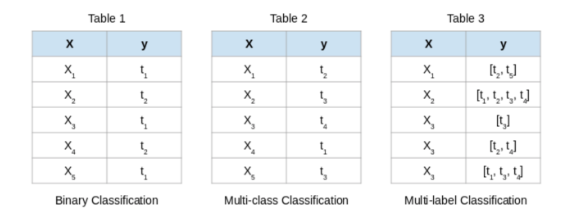

**Feature Extraction**: TF-IDF algorithm will be used to give each word in our titles weight to input into the models.

**Prediction models**: Multinomial Naive Bayes and Logistic Regression will be compared.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1,2))

# split dataset into training and validation set
y = df.Genre
x = df.Name
xtrain, xval, ytrain, yval = train_test_split(x,y, test_size = 0.2)

# create the TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn import metrics

mnb = MultinomialNB()
lr = LogisticRegression(max_iter=1000)

# fit model on train data
mnb.fit(xtrain_tfidf, ytrain)
lr.fit(xtrain_tfidf, ytrain)

# make predictions for validation set
mnb_pred = mnb.predict(xval_tfidf)
lr_pred = lr.predict(xval_tfidf)

# evaluate performance
mnb_acc = metrics.accuracy_score(yval, mnb_pred)
mnb_acc = round(mnb_acc,2)
lr_acc = metrics.accuracy_score(yval, lr_pred)
lr_acc = round(lr_acc,2)

In [ ]:
print(f"Accuracy Scores:\nMultinomial Naive Bayes: {mnb_acc}")
print(f"Logistic Regression: {lr_acc}")

Logistic Regression achieved a higher accuracy score of over 70% and will be chosen.

## Sample predictions

In [ ]:
pred_df = pd.DataFrame(xval)
pred_df['actual'] = yval
pred_df['prediction'] = lr_pred
pred_df.sample(10)

With over 70% accuracy, the above sample shows the model was able to correctly classify most of the video game titles except there are cases of mis-classification for games in similar genres where the word use will likely be similar. Such as Strategy, Action and Adventure to name a few.

## Conclusion

From this it can be seen that with just the titles as features it is possible to capture the correlation with Genre and predict on unseen data. This can be further built upon should there be synopsis data on video games, and other mediums.

Some steps to be taken to improve classification accuracy:
 - Employ Under / Over sampling strategy to reduce class imbalance.
 - Explore other models
 - Use cross validation and hyperparameter tune models

A use case for this type of classification was automating data entry tasks as data can come without classification.